<img src="../img/hu-logo.png" align="right" width="120">

# Tree-based models

In this notebook we'll implement a simple solution to homework 2, part 3.

This includes the following steps:
1. Define the target variable
2. Build training index (i.e., define how to construct training samples) and build a small set of features
3. Baselines
4. Random Forest
5. Boosted Tree
6. Benchmark results
7. Calibration curve
8. Permutation feature importance

In [1]:
import json
import os
import pickle

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.calibration
import sklearn.ensemble
import sklearn.inspection
import sklearn.metrics
import sklearn.model_selection
import sklearn.tree
import statsmodels.api as sm
import tqdm

In [2]:
# set some default pyplot parameters
plt.rcParams.update(
    {
        "figure.figsize": (10, 8),
        "axes.titlesize": 20,
        "axes.labelsize": 15,
        "legend.fontsize": 15,
        "legend.title_fontsize": 15,
        "axes.grid": True,
        "axes.axisbelow": True,
        "pcolor.shading": "auto",
    }
)

In [3]:
# set your path here
PATH = os.path.expanduser("/private/data/teaching/instacart_exercise_2")

## Load data

In [4]:
# load data
products = pd.read_parquet(f"{PATH}/products.parquet")
baskets = pd.read_parquet(f"{PATH}/baskets.parquet")
orders = pd.read_parquet(f"{PATH}/orders.parquet")
prediction_index = pd.read_parquet(f"{PATH}/prediction_index.parquet")

## Define the target variable

We predict days to next order so shift `days_since_prior_order` by 1 order
- Binary target variable derived from `y` ("days to next order")
- We can construct multiple training samples for each user
- The prediction target is the last observation for each shopper (where y is not available)

In [5]:
# we sort orders so we can simply shift by `-1` in the next step
# first and last values for `days_since_prior_order` are NaN
orders = orders.sort_values(["user_id", "order_number"], ascending=True)

In [6]:
orders

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0
2,473747,1,3,3,12,21.0
3,2254736,1,4,4,7,29.0
4,431534,1,5,4,15,28.0
...,...,...,...,...,...,...
3214869,2558525,206209,9,4,15,22.0
3214870,2266710,206209,10,5,18,29.0
3214871,1854736,206209,11,4,10,30.0
3214872,626363,206209,12,1,12,18.0


In [7]:
# verify that first `days_since_prior_order` values for all shoppers are NaN
# and that the last `days_since_prior_order` values for all shoppers are not NaN
# this is a prerequsite for simply shifting by -1, regardless of `user_id`
assert np.all(orders.groupby("user_id").days_since_prior_order.head(1).isnull())
assert np.all(orders.groupby("user_id").days_since_prior_order.tail(1).notnull())

In [8]:
orders["y_int_l1"] = (orders["days_since_prior_order"] <= 14).astype(int)
orders["y"] = orders["days_since_prior_order"].shift(-1)
orders["y_int"] = (orders["y"] <= 14).astype(int)

## Some light data preprocessing

In [9]:
# add number of products per baskets
n_product_order = baskets.groupby("order_id")[["product_id"]].nunique().reset_index()
n_product_order.rename(columns={"product_id": "size"}, inplace=True)
orders = orders.merge(n_product_order, on="order_id", how="left").reset_index(drop=True)

In [10]:
# inverse order counter (used in building training data)
orders["order_number_inv"] = (
    orders.groupby("user_id").order_number.transform(max) - orders["order_number"]
)

In [11]:
# shorten variable names
orders.rename(columns={"days_since_prior_order": "dspo"}, inplace=True)

### Let's look at one single user

In [12]:
prediction_index[prediction_index["user_id"] == 5]

,user_id,order_number
4,5,5


In [13]:
orders[orders["user_id"] == 5]

,order_id,user_id,order_number,order_dow,order_hour_of_day,dspo,y_int_l1,y,y_int,size,order_number_inv
41,2717275,5,1,3,12,NaN,0,11.0,1,11,3
42,1909121,5,2,0,16,11.0,1,10.0,1,9,2
43,2267326,5,3,3,18,10.0,1,19.0,0,5,1
44,157374,5,4,1,18,19.0,0,NaN,0,12,0


In [14]:
orders[orders["user_id"] == 1]

,order_id,user_id,order_number,order_dow,order_hour_of_day,dspo,y_int_l1,y,y_int,size,order_number_inv
0,2539329,1,1,2,8,NaN,0,15.0,0,5,9
1,2398795,1,2,3,7,15.0,0,21.0,0,6,8
2,473747,1,3,3,12,21.0,0,29.0,0,5,7
3,2254736,1,4,4,7,29.0,0,28.0,0,5,6
4,431534,1,5,4,15,28.0,0,19.0,0,8,5
5,3367565,1,6,2,7,19.0,0,20.0,0,4,4
6,550135,1,7,1,9,20.0,0,14.0,1,5,3
7,3108588,1,8,1,14,14.0,1,0.0,1,6,2
8,2295261,1,9,1,16,0.0,1,30.0,0,6,1
9,2550362,1,10,4,8,30.0,0,NaN,0,9,0


## Build training data

We create training/testing samples for each value of `order_number_inv`, starting with 0:
- `order_number_inv=0` is our test set
- `order_number_inv>0` is our training/validation set

Not all shoppers have observations for a given `o`, this depends on length of their order history.  Also note that we keep all data prior to `o`, regardless of the length of the order history.  This means that we use a different amount of data in building features across shoppers.  Our reason for doing this is that we do not have trending features (in this case we need to either normalize or use a constant time window) and that more data yields more accurate feature values for the given statistics.  We avoid leakage by only using data available at each given point in time (i.e., before the next order).  Consider replacing min/max by percentiles (e.g., 10% and 90%) to deal with outliers.

Note, we already introduce three hyperparameters here:
- the number of observations used for constructing our feature data `O`
- the lags used in feature computation `L`
- our feature set (e.g., base variables, aggregation functions)

In [15]:
O = 10
L = [100_000, 3, 5]

x_list = []
y_list = []
for o in tqdm.tqdm(range(0, O)):

    data_sets = []

    for i, l in enumerate(L):

        orders_o_l = orders[
            (orders["order_number_inv"] >= o) & (orders["order_number_inv"] < (o + l))
        ]

        if i == 0:
            features_o_l = orders_o_l.groupby("user_id").agg(
                {
                    "dspo": ["last", "mean", "min", "max"],
                    "size": ["last", "mean", "min", "max"],
                    "y_int_l1": ["last", "mean"],
                }
            )
        else:
            features_o_l = orders_o_l.groupby("user_id").agg(
                {
                    "dspo": ["mean", "min", "max"],
                    "size": ["mean", "min", "max"],
                    "y_int_l1": ["mean"],
                }
            )

        features_o_l.columns = ["_".join(c) for c in features_o_l.columns.values]

        if i > 0:
            features_o_l.columns = [f"{c}_l{l}" for c in features_o_l.columns]

        data_sets.append(features_o_l)

    # merge
    data_o = data_sets[0]
    for i in range(1, len(data_sets)):
        data_o = data_o.merge(data_sets[i], on="user_id")

    # additional (derived) features
    # add 1 because `dspo_mean` can be 0
    data_o["ratio_dspo"] = data_o["dspo_last"] / (
        1 + data_o["dspo_mean"]
    )
    data_o["ratio_size"] = data_o["size_last"] / data_o["size_mean"]
    data_o["trend_dspo"] = data_o["dspo_mean"] - data_o[f"dspo_mean_l{min(L)}"]
    data_o["trend_size"] = data_o["size_mean"] - data_o[f"size_mean_l{min(L)}"]

    # write to list
    data_o["order_number_inv"] = o
    x_list.append(data_o)
    y_list.append(
        orders[orders["order_number_inv"] == o][
            ["user_id", "order_number_inv", "y_int"]
        ]
    )

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [16]:
# data set for making final predictions
X_predict = x_list[0].reset_index().set_index(["user_id", "order_number_inv"]).values
y_predict = None

In [17]:
# train and test dat
x_df = pd.concat(x_list[1:]).reset_index().set_index(["user_id", "order_number_inv"])
y_df = pd.concat(y_list[1:])
features = x_df.columns

# remove NaNs
mask_not_null = x_df["dspo_last"].notnull().values
y_df = y_df[mask_not_null]
x_df = x_df[mask_not_null]
assert x_df["dspo_last"].isnull().sum() == 0

# create validation set by split in time dimension
mask = (x_df.reset_index().order_number_inv > 1).values

X_test = x_df[~mask].values
X_train = x_df[mask].values

y_test = y_df[~mask].y_int.values
y_train = y_df[mask].y_int.values

## Baseline 1: Random predictions

We expect an AUC of .5 for random probabilities.

In [18]:
random = prediction_index.copy()
random["yhat"] = np.random.uniform(0, 1, random.shape[0])
random.head()

,user_id,order_number,yhat
0,1,11,0.304813
1,2,15,0.451061
2,3,13,0.218883
3,4,6,0.000427
4,5,5,0.290249


## Baseline 2: Management heuristic

Use the last observation for `y` ("shopping trip in next two weeks") as a prediction.

In [19]:
last_obs = (
    y_df[y_df["order_number_inv"] == 1][["user_id", "y_int"]]
    .merge(prediction_index, on="user_id")
    .rename(columns={"y_int": "yhat"})
).sort_values("user_id")
last_obs.head()

,user_id,yhat,order_number
0,1,0,11
1,2,1,15
2,3,0,13
3,4,1,6
4,5,0,5


## Random Forest

### Train and evaluate model

In [20]:
parameters_rf = {
    "n_estimators": 100,
    "min_samples_split": 16,
    "max_leaf_nodes": 48,
    "max_features": 0.8,
    "max_depth": 5,
    "bootstrap": True,
    "random_state": 501,
}

In [21]:
random_forest = sklearn.ensemble.RandomForestClassifier(**parameters_rf)
random_forest.fit(X_train, y_train)
sklearn.metrics.roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])

0.7541044050523816

### Retrain model on full data and predict

In [22]:
parameters_rf_star = parameters_rf.copy()
# or do a parameter search instead (random search, bayesian optimziation, etc.)

In [23]:
random_forest_star = sklearn.ensemble.RandomForestClassifier(**parameters_rf_star)

In [24]:
random_forest_star.fit(
    x_df.values,
    y_df.y_int.values,
)

RandomForestClassifier(max_depth=5, max_features=0.8, max_leaf_nodes=48,
                       min_samples_split=16, random_state=501)

### Build prediction for final evaluation

In [25]:
pred_rf = prediction_index.copy()
pred_rf["yhat"] = random_forest_star.predict_proba(X_predict)[:, 1]
assert pred_rf["yhat"].isnull().sum() == 0
pred_rf.head()

,user_id,order_number,yhat
0,1,11,0.448045
1,2,15,0.564945
2,3,13,0.605164
3,4,6,0.541756
4,5,5,0.497535


## Boosted Tree

### Hyperparameter search

We start with a random search for hyperparameters.  This will randomly select combinations of hyperparameters from a "grid" (not really a grid, rather ranges in each hyperparameter dimension), evaluate them on the training data (using cross validation), and return the values that perform the best.

Note that it would be better touse a split in the time dimension here as well. We can do this by providing an iterable that yields indices to `cv` in `sklearn.model_selection.RandomizedSearchCV`.  Why not go ahead and try this modification?  Does this improve the results for our hyperparameter search?

In [26]:
file_hps_results = f"{PATH}/random_search_lgbm.pickle"
# file_hps_results = f"{PATH}/random_search_lgbm_v1.pickle"
# file_hps_results = f"{PATH}/random_search_lgbm_v2.pickle"

if os.path.isfile(file_hps_results):

    # load prior results
    with open(file_hps_results, "rb") as con:
        randomized_search = pickle.load(con)

    # print results and extract best parameters
    print(randomized_search.best_score_)
    print(json.dumps(randomized_search.best_params_, indent=4))
    lgbm_parameters_star = randomized_search.best_params_

else:

    # run hyperparameter search
    param_grid = {
        "boosting_type": ["gbdt", "dart"],
        "num_leaves": range(10, 200, 5),
        "max_depth": range(1, 20, 1),
        "learning_rate": [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
        "n_estimators": [500, 750, 1000, 1250, 1500, 2000],
        "objective": ["binary"],
        "metric": ["auc"],
        "bagging_fraction": np.arange(0.4, 1, 0.1),
        "bagging_freq": range(1, 5, 1),
        "feature_fraction": np.arange(0.4, 1, 0.1),
        "max_bin": range(10, 500, 10),
        "min_data_in_leaf": range(5, 50, 1),
    }

    lightgbm_classifier = lightgbm.LGBMClassifier()

    randomized_search = sklearn.model_selection.RandomizedSearchCV(
        estimator=lightgbm_classifier,
        param_distributions=param_grid,
        cv=5,  # here we should implement a better split strategy
        n_iter=250,
        n_jobs=-1,
        scoring="roc_auc",
        verbose=2,
        random_state=501,
    )

    randomized_search.fit(X_train, y_train)

    with open(file_hps_results, "wb") as con:
        pickle.dump(randomized_search, con)

0.7681258458259328
{
    "objective": "binary",
    "num_leaves": 125,
    "n_estimators": 750,
    "min_data_in_leaf": 22,
    "metric": "auc",
    "max_depth": 5,
    "max_bin": 390,
    "learning_rate": 0.1,
    "feature_fraction": 0.4,
    "boosting_type": "dart",
    "bagging_freq": 1,
    "bagging_fraction": 0.8999999999999999
}


### Retrain model on full data and predict

In [27]:
lightgbm_classifier_star = lightgbm.LGBMClassifier(**lgbm_parameters_star)

In [28]:
lightgbm_classifier_star.fit(
    x_df.values,
    y_df.y_int.values,
)

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] bagging_fraction is set=0.8999999999999999, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8999999999999999
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.8999999999999999, bagging_freq=1,
               boosting_type='dart', feature_fraction=0.4, max_bin=390,
               max_depth=5, metric='auc', min_data_in_leaf=22, n_estimators=750,
               num_leaves=125, objective='binary')

In [29]:
pred_lgbm = prediction_index.copy()
pred_lgbm["yhat"] = lightgbm_classifier_star.predict_proba(X_predict)[:, 1]
assert pred_lgbm["yhat"].isnull().sum() == 0
pred_lgbm.head()

,user_id,order_number,yhat
0,1,11,0.362277
1,2,15,0.560907
2,3,13,0.569564
3,4,6,0.397036
4,5,5,0.485283


## BENCHMARK

After you executed the following lines you should not go back and change your models. This is the final evaluation after you are done with model training/evaluation. If you still want to improve your models build an appropriate ___validation data___ set and evaluate your models on that data. Once you test your models on the truth data you should not iterate on your models anymore.

<img src="../img/no-return.png" width=800>

In [31]:
def score(x):
    truth = pd.read_parquet(f"{PATH}/truth.parquet")
    assert np.all(
        truth[["user_id", "order_number"]].values
        == x[["user_id", "order_number"]].values
    )
    return sklearn.metrics.roc_auc_score(truth["y"].values, x["yhat"].values)

In [32]:
score(random)

0.4991888604925711

In [33]:
score(last_obs)

0.6557106576947312

In [34]:
score(pred_rf)

0.7602472162814088

In [35]:
score(pred_lgbm)

0.766374299061195

## Calibration cuves

The following plot compares how well the probabilistic predictions of our classifiers are calibrated, using calibration_curve. The `x`-axis represents the average predicted probability in each bin. The `y`-axis is the fraction of positives, i.e. the proportion of samples whose class is the positive class (in each bin).

### sklearn implementation

In [36]:
truth = pd.read_parquet(f"{PATH}/truth.parquet")

In [37]:
results_dict = {
    "lgbm": pred_lgbm["yhat"].values,
    "random-forest": pred_rf["yhat"].values,
}

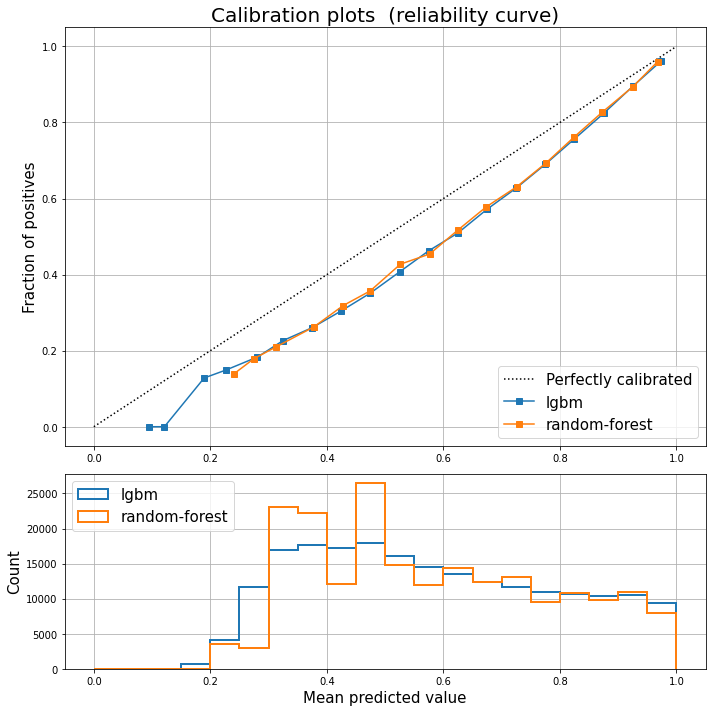

In [38]:
# https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for name in results_dict:
    prob_pos = results_dict[name]
    fraction_of_positives, mean_predicted_value = sklearn.calibration.calibration_curve(
        truth["y"].values, prob_pos, n_bins=20
    )

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (name,))
    ax2.hist(prob_pos, range=(0, 1), bins=20, label=name, histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title("Calibration plots  (reliability curve)")

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

### Our own implementation

In [39]:
# some questions to think about:
# do you see what we are doing here?
# why do we sample from a `Beta` distribution?
# what do the following parameters of the Beta distribution mean?
#   - `1+x["y"]["sum"]`
#   - the `1` in `1+x["y"]["sum"]`
#   - `1+x["y"]["len"]-x["y"]["sum"]`
#   - the `1` in `1+x["y"]["len"]-x["y"]["sum"]`
# what do we get from `np.quantile(posterior, .025)` and `np.quantile(posterior, .975)`


def sample_posterior(x, N=10_000):
    posterior = np.random.beta(1 + x["y"]["sum"], 1 + x["y"]["len"] - x["y"]["sum"], N)
    return pd.Series(
        [
            np.mean(posterior),
            np.quantile(posterior, 0.025),
            np.quantile(posterior, 0.975),
        ]
    )

In [40]:
def get_agg(x, l, w=0.05):
    out = pd.read_parquet(f"{PATH}/truth.parquet").merge(
        x, on=["user_id", "order_number"]
    )
    out["bin"] = out["yhat"] // w
    agg = out.groupby("bin")[["y", "yhat"]].agg([np.mean, len, sum]).reset_index()
    agg["label"] = l
    agg[["mean", "p025", "p975"]] = agg.apply(lambda row: sample_posterior(row), axis=1)
    agg["mean_yhat"] = agg["yhat"]["mean"]
    agg["n"] = agg["yhat"]["len"]

    return agg[["label", "mean_yhat", "mean", "p025", "p975", "n"]]

In [41]:
plot_data = pd.concat([get_agg(pred_lgbm, "lgbm"), get_agg(pred_rf, "random-forest")])

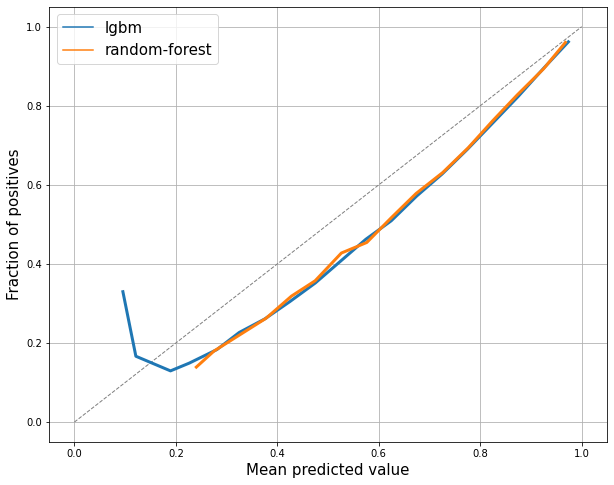

In [42]:
plt.plot([0, 1], [0, 1], c="grey", linewidth=1, linestyle="--")
g = sns.lineplot(x="mean_yhat", y="mean", data=plot_data, linewidth=3, hue="label")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
g.legend_.set_title(None)

Any idea what causes the differences between our custom implementation and the `sklearn` version?

## Study features using permutation feature importance

In [43]:
res_pi = sklearn.inspection.permutation_importance(
    random_forest,
    X_test,
    y_test,
    n_repeats=5,
    random_state=501,
)

In [44]:
for i in res_pi.importances_mean.argsort()[::-1]:
    if res_pi.importances_mean[i] - 2 * res_pi.importances_std[i] > 0:
        print(
            f"{features[i]:<20} {res_pi.importances_mean[i]:.6f} ± {res_pi.importances_std[i]:.6f}"
        )

dspo_mean_l5         0.059357 ± 0.000512
y_int_l1_mean        0.057267 ± 0.000265
dspo_mean_l3         0.008261 ± 0.000122
dspo_last            0.003985 ± 0.000186
dspo_mean            0.001265 ± 0.000219
y_int_l1_mean_l5     0.000660 ± 0.000093
ratio_dspo           0.000145 ± 0.000063
dspo_max_l3          0.000073 ± 0.000027
dspo_max             0.000008 ± 0.000002


&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Lecture 5 <br>
2020 <br>